# Assignment 1
Learning Outcomes
Understand how competive learning works.
Ability to develop and tune a simple neural network using competitive learning.

In [1]:
#imports
import numpy as np
import numpy.matlib
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the Dataset

In [2]:
##########################

train2 = np.genfromtxt ('letters.csv', delimiter=",")
trainlabels = np.genfromtxt ('letterslabels.csv', delimiter=",")

#set the seed for the numpy random functions (used to create same conditions)
np.random.seed(8)

[7744, 7000]


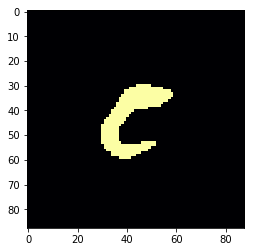

In [75]:
train = train2
############################# created copy of train so dont need to keep loading
[n,m]  = np.shape(train)                    # number of pixels and number of training data
pix = int(math.sqrt(n))
image = np.reshape(train[:,10],(pix,pix),order="F")
plt.imshow(image, cmap = 'inferno');

print([n,m])

#### parameters and variables

In [76]:
[n,m]  = np.shape(train)                    # number of pixels and number of training data
#number of pixels is 7744 (88*88)
#number of training data examples is 7000

eta    = 0.05                             # learning rate
winit  = 1                                 # parameter controlling magnitude of initial conditions
alpha = 0.999

tmax   = 20000                            #number of training instances
digits = 20                               #number of digits

wMatrix = winit * np.random.rand(digits,n)        # Weight matrix (rows = output neurons, cols = input neurons)
normW = np.sqrt(np.diag(wMatrix.dot(wMatrix.T)))
normW = normW.reshape(digits,-1)  # reshape normW into a numpy 2d array
wMatrix = wMatrix / normW                           # normalise using numpy broadcasting -  http://docs.scipy.org/doc/numpy-1.10.1/user/basics.broadcasting.html

#make a copy of the inital weights matrix
INITIAL_W=np.array(wMatrix)

counter = np.zeros((1,digits))              # counter for the winner neurons
wCount = np.ones((1,tmax+1)) * 0.25         # running avg of the weight change over time

#normalise the dataset
norm = np.atleast_1d(np.linalg.norm(train, ord =2, axis =0))
norm[norm==0] = 1
train = train / np.expand_dims(norm, axis = 0)
[n,m]  = np.shape(train)

#check train data is normalized
print(numpy.linalg.norm(train[:,1]))


1.0
1.0


#### Implementation, training and ouput

In [77]:
rate=1
for t in range(1,tmax):
    i = math.ceil(m * np.random.rand())-1  # get a randomly generated index in the input range
    x = train[:,i]                          # pick a training instance using the random index

    h = wMatrix.dot(x)/digits               # get output firing
    h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

    output = np.max(h)                      # get the max in the output firing vector
    k = np.argmax(h)                        # get the index of the firing neuron
       
    #decaying learning rate
    #eta = (eta/tmax)*(tmax-t/1000)          #learning rate decays for each output firing until tmax
    
    counter[0,k] += 1                       # increment counter for winner neuron
                                            
        
    dw = eta * (x.T - wMatrix[k,:])         # calculate the change in weights for the k-th output neuron
                                            # get closer to the input (x - W)

    wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # % weight change over time (running avg)
    
    wMatrix[k,:] = wMatrix[k,:] + dw                # weights for k-th output are updated
    
    
#        #update neighboring losers 
#     if (k-1 >= 0):                            #get the index of the next to the winning neuron
#         dw = eta * (x.T - wMatrix[k-1,:])     #get the weight change for the k-1 neuron
#         wMatrix[k-1,:] += dw                  #update the k-1 neuron
#     else:
#         dw = eta * (x.T - wMatrix[digits-1,:])
#         wMatrix[digits-1,:] += dw 
#     if (k+1 < digits):
#         dw = eta * (x.T - wMatrix[k+1,:])
#         wMatrix[k+1,:] += dw 
#     else:
#         dw = eta * (x.T - wMatrix[0,:])
#         wMatrix[0,:] += dw
    
      # leaky learning
    for s in range(0, digits):                      #loop over the number of neurons
        if (s != k):
            low_eta = eta / 1000                   #set a learning rate that is much lower than that of the winner neuron
            dw = low_eta * (x.T - wMatrix[s,:])     #get the change in weight for neuron index s
            wMatrix[s,:] += dw                      #update the weights of the s indexed neuron   
    
    
    #adding noise to weights
    mu, sigma = 0, 0.00005                            #set a noise value threshold
    noise = np.random.normal(mu, sigma, wMatrix.shape) #generate a noise matrix the same size as the weight matrix
    wMatrix[k,:] += noise[k,:]                         #apply the noise matrix to the weights matrix

#### Displaying the Number of types Each Neuron Fired

[[ 2626.   274.   749.    95.   373.    75.    92.   175.   281.  3742.
   2986.   521.   766.  3643.   532.    40.   508.   512.  1420.   589.]]


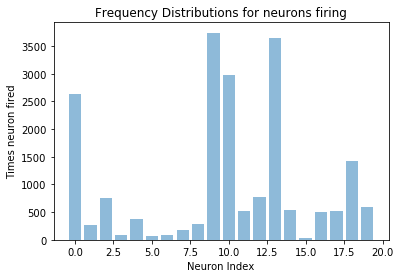

In [78]:
print(counter)

#flattens the 2-dimensional numpy array into a one dimensional array
counter = counter.flatten()
y_pos = np.arange(len(counter))

#plots a graph of the number of times each neuron fired
plt.bar(y_pos, counter, align='center', alpha=0.5)
plt.ylabel('Times neuron fired')
plt.xlabel('Neuron Index')
plt.title('Frequency Distributions for neurons firing')
plt.show()

#### number of prototypes network found and correlation matrix between the prototypes

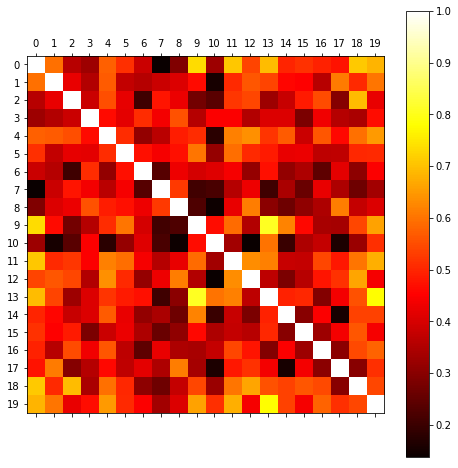

In [79]:
#calculate correlation matrix
correlation_matrix = np.corrcoef(wMatrix)

#plot the correlation matrix
plt.figure(figsize=(8,8))
plt.matshow(correlation_matrix, fignum=1, cmap='hot')
plt.xticks(range(len(correlation_matrix[0])))
plt.yticks(range(len(correlation_matrix[0])))

# Add colorbar
plt.colorbar()
plt.show()

#### calculate number of dead units

In [80]:
[i,j]  = np.shape(correlation_matrix)
counter = 0
deadUnits = np.zeros((1,digits))  

#sum all the weights for each prototype
sums = wMatrix.sum(axis=1)
print(sums)

#if the sum of a prototypes weights is greater than 40 it is considered a dead unit
for y in range(j):
    if (sums[y] > 40):
            deadUnits[0,y] += 1 
            counter +=1

#calculates the number of dead units by recursing through the correlation matrix and
#comparing the correlation between prototypes. If a prototype is has a threshold higher than
#0.8 when compared to a previous non-dead unit is classified as a dead unit.

for y in range(j):
    if (deadUnits[0,y] == 0) :
        for x in range(i):
            if (deadUnits[0,x] == 0):
                if (correlation_matrix[x,y] > 0.8 and correlation_matrix[x,y] != 1):
                    deadUnits[0,x] += 1 
                    counter +=1

#print the indexed positions of the dead units and the number of dead units
print(deadUnits)
print("number of dead units: " + str(counter))

[ 25.73213382  28.37194627  31.97518005  33.91828008  28.03529321
  29.28962493  34.44836497  33.51843089  32.99118308  22.3648265
  14.55951451  26.66231995  30.47915948  22.40853497  20.45786514
  32.60743047  27.75824439  32.44993328  28.75429079  27.18689569]
[[ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.
   0.  1.]]
number of dead units: 8


#### Plotting the prototypes

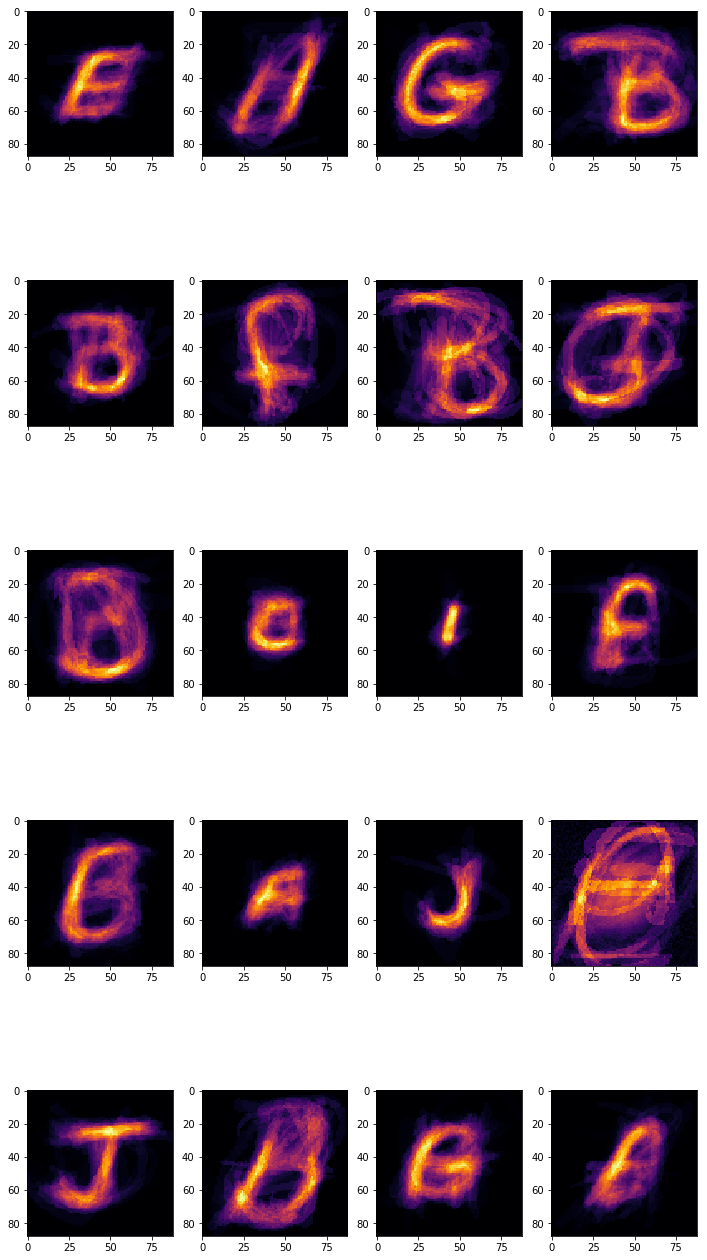

In [81]:
#plot all the prototypes
w=15
h=15
fig=plt.figure(figsize=(12, 24))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(wMatrix[i-1,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='inferno')
plt.show()

# Plot a prototype
#plt.imshow(W[10,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='inferno')


#### figure showing the average weight change as a function of time

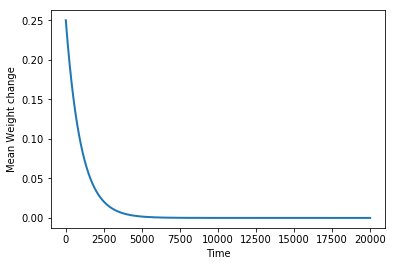

In [82]:
# Plot running average
plt.plot(wCount[0,0:tmax], linewidth=2.0, label='rate')
plt.ylabel('Mean Weight change')
plt.xlabel('Time')
plt.show()